In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Read 
file = pd.ExcelFile("..\data\\food-twentieth-century-crop-statistics-1900-2017-xlsx.xlsx")
df = file.parse('CropStats')
df = df.set_index(df.columns[0])
df.index.name = None


The way I understand it the sheet 'CropStats' contains all data from the other sheets, so I am only using that one.


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36707 entries, 0 to 36706
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Harvest_year         36707 non-null  int64  
 1   admin0               36707 non-null  object 
 2   admin1               33716 non-null  object 
 3   crop                 36707 non-null  object 
 4   hectares (ha)        35084 non-null  float64
 5   production (tonnes)  34709 non-null  float64
 6   year                 36707 non-null  int64  
 7   yield(tonnes/ha)     34694 non-null  float64
 8   admin2               0 non-null      float64
 9   notes                5641 non-null   object 
dtypes: float64(4), int64(2), object(4)
memory usage: 3.1+ MB


In [4]:
df.head()

,Harvest_year,admin0,admin1,crop,hectares (ha),production (tonnes),year,yield(tonnes/ha),admin2,notes
0,1902,Austria,NaN,wheat,NaN,NaN,1902,1.31,NaN,NaN
1,1903,Austria,NaN,wheat,NaN,NaN,1903,1.47,NaN,NaN
2,1904,Austria,NaN,wheat,NaN,NaN,1904,1.27,NaN,NaN
3,1905,Austria,NaN,wheat,NaN,NaN,1905,1.33,NaN,NaN
4,1906,Austria,NaN,wheat,NaN,NaN,1906,1.28,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36707 entries, 0 to 36706
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Harvest_year         36707 non-null  int64  
 1   admin0               36707 non-null  object 
 2   admin1               33716 non-null  object 
 3   crop                 36707 non-null  object 
 4   hectares (ha)        35084 non-null  float64
 5   production (tonnes)  34709 non-null  float64
 6   year                 36707 non-null  int64  
 7   yield(tonnes/ha)     34694 non-null  float64
 8   admin2               0 non-null      float64
 9   notes                5641 non-null   object 
dtypes: float64(4), int64(2), object(4)
memory usage: 3.1+ MB


based on the amount off null values I am starting by omitting admin2 (0 non-null) and notes (5641), also don't think those would have been meaningful regardless.

In [6]:
df.drop(['admin2', 'notes', 'Harvest_year'], axis=1, inplace=True)

admin0 indicates the national levels (countries).  
admin1 indicates the subnational levels (states).  
this is confusing for me so i am changing the column names.

In [7]:
df.rename(columns = {'admin0': 'national', 'admin1': 'subnational', 'hectares (ha)': 'hectares_ha', 'production (tonnes)': 'production_tonnes', 'yield(tonnes/ha)': 'yield_tonnes_ha'}, inplace=True)

In [8]:
df.loc[df['subnational'].isna(), 'subnational'] = df['national']

hectares, production and yield have some null values  
<del>I have decided to remove all rows with null values in these columns as i think these are the most important columns  
this leaves us with 33477 rows (still 91.20% of the original 36707) which i believe to still be plenty  
I think simply omitting these is a better idea than replacing them with averages for these two reasons</del>  

if yield is nan, but hectares and production are not, we can calculate yield. This occurs 1115 times. Other rows with NaN for yield are dropped. we also cannot calculate the yield when hectares is 0, this would give inf yield.

In [9]:
len(df[(pd.isnull(df['yield(tonnes/ha)'])) & (~pd.isnull(df['production (tonnes)'])) & ~pd.isnull(df['hectares (ha)'])])


1115

In [10]:
mask = df['yield(tonnes/ha)'].isna() & ~df['production (tonnes)'].isna() & ~df['hectares (ha)'].isna() & df['hectares (ha)'] != 0
df.loc[mask, 'yield(tonnes/ha)'] = df['production (tonnes)'] / df['hectares (ha)']
df.dropna(subset=['yield(tonnes/ha)'], inplace=True)


if production is nan, but hectares and yield are not, we can calculate production. This occurs 483 times. Other rows where production is NaN are dropped.

In [11]:
len(df[~pd.isnull(df['hectares (ha)']) & pd.isnull(df['production (tonnes)']) & ~pd.isnull(df['yield(tonnes/ha)'])])


483

In [12]:
# The mask is used here because of I did the same way as above it kept timing out
mask = df['production (tonnes)'].isna() & ~df['yield(tonnes/ha)'].isna() & ~df['hectares (ha)'].isna()
df.loc[mask, 'production (tonnes)'] = df['yield(tonnes/ha)'] * df['hectares (ha)']
df.dropna(subset=['production (tonnes)'], inplace=True)


if hectares is NaN, and production and yield are not, hectares can be calculated, this occurs 106 times. Other rows where hectares is NaN are dropped.

In [13]:
mask = df['hectares (ha)'].isna() & ~df['yield(tonnes/ha)'].isna() & ~df['production (tonnes)'].isna()
df.loc[mask, 'hectares (ha)'] = df['yield(tonnes/ha)'] * df['production (tonnes)']
df.dropna(subset=['hectares (ha)'], inplace=True)

In [14]:
# The columns we just adapted just changed into objects, let's make them floats again
df['hectares (ha)'] = df['hectares (ha)'].astype(float)
df['production (tonnes)'] = df['production (tonnes)'].astype(float)
df['yield(tonnes/ha)'] = df['yield(tonnes/ha)'].astype(float)

In [15]:
# Assuming df is your DataFrame
zero_hectares_rows = df[df['hectares (ha)'] == 0]

# Print or display the rows where 'hectares (ha)' is 0
print(zero_hectares_rows)

Empty DataFrame
Columns: [national, subnational, crop, hectares (ha), production (tonnes), year, yield(tonnes/ha)]
Index: []


In [16]:
df.describe()

,hectares (ha),production (tonnes),year,yield(tonnes/ha)
count,3.415500e+04,3.415500e+04,34155.000000,34155.000000
mean,6.745161e+05,1.634547e+06,1956.119836,2.679773
std,1.616353e+06,5.003067e+06,38.730405,2.239175
min,1.000000e+00,0.000000e+00,1861.000000,0.000000
25%,3.642120e+04,7.022915e+04,1927.000000,1.137703
50%,1.800826e+05,3.302174e+05,1959.000000,1.881500
75%,6.426318e+05,1.243900e+06,1989.000000,3.486162
max,3.147000e+07,1.342875e+08,2019.000000,17.168477


We have a lot of hectares = 0, like a lot, let's see how things change when we drop those

In [17]:
df = df[df['hectares (ha)'] != 0]

In [18]:
df['log_yield'] = np.log1p(df['yield(tonnes/ha)'])


<Axes: xlabel='crop', ylabel='log_yield'>

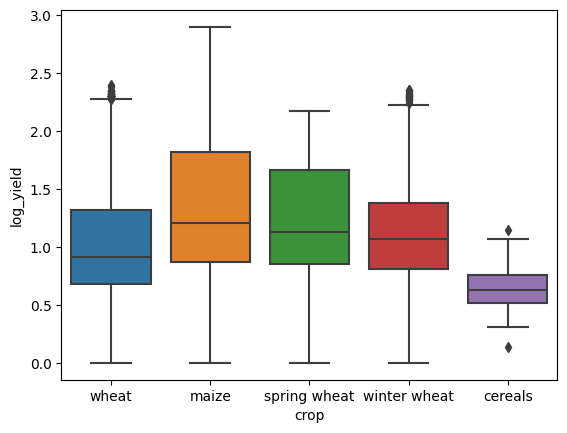

In [19]:
sns.boxplot(data=df, x='crop', y='log_yield')

In [20]:
df['log_hectares'] = np.log1p(df['hectares (ha)'])


<Axes: xlabel='crop', ylabel='log_hectares'>

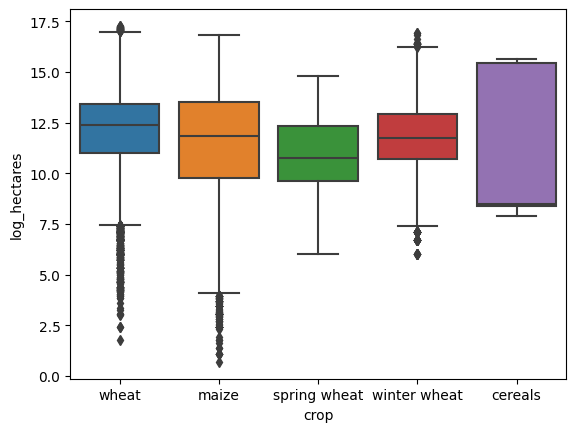

In [21]:
sns.boxplot(data=df, x='crop', y='log_hectares')


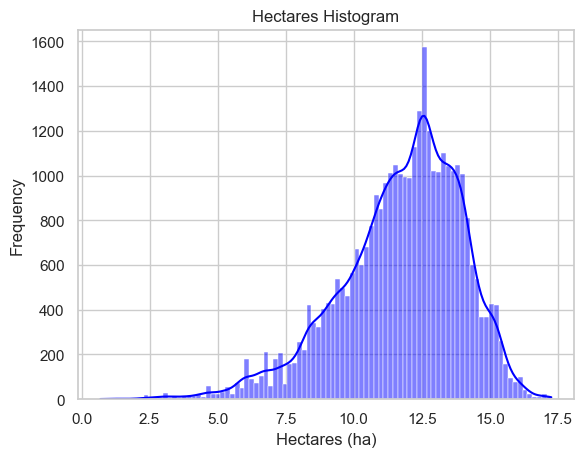

In [22]:
# Assuming df is your DataFrame
sns.set(style="whitegrid")  # Set a seaborn style

# Plot the histogram
sns.histplot(data=df, x='log_hectares', kde=True, color='blue')

# Add labels and title
plt.xlabel('Hectares (ha)')
plt.ylabel('Frequency')
plt.title('Hectares Histogram')

# Show the plot
plt.show()

In [23]:
df['log_production'] = np.log1p(df['production (tonnes)'])


<Axes: xlabel='crop', ylabel='log_production'>

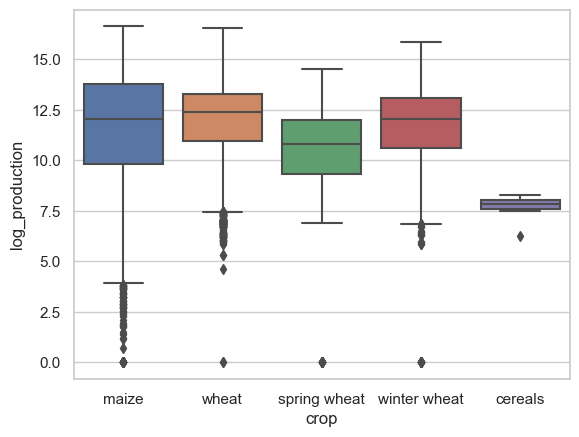

In [24]:
sns.boxplot(data=df[df['year'] < 1950], x='crop', y='log_production')


this last one seems to show outliers for spring wheat, winter wheat, and maybe wheat, these appear in earlier years (before 1950)

we log transformed the hectares, yield, and production which gives us values that are easier to work with (this type of transformation is a very common thing to do when dealing with a lot of small values/very skewed data)

I think we should work with admin0, admin1, and crop through one hot encoding.  

In [25]:
# crop = pd.get_dummies(df['crop'])
# crop

# # Merge the one-hot encoded columns back into the original DataFrame
# df = pd.concat([df, crop], axis=1)

# # Drop the original 'age category' column if needed
# df = df.drop(columns=['crop'])

df

,national,subnational,crop,hectares (ha),production (tonnes),year,yield(tonnes/ha),log_yield,log_hectares,log_production
59,Austria,Austria,wheat,275822.0,711620.760,1961,2.580000,1.275363,12.527515,13.475302
60,Austria,Austria,wheat,270351.0,706156.812,1962,2.612000,1.284262,12.507480,13.467594
61,Austria,Austria,wheat,274722.0,689552.220,1963,2.510000,1.255616,12.523519,13.443799
62,Austria,Austria,wheat,282967.0,750428.484,1964,2.652000,1.295275,12.553089,13.528401
63,Austria,Austria,wheat,275654.0,660742.638,1965,2.397000,1.222893,12.526905,13.401121
...,...,...,...,...,...,...,...,...,...,...
36702,China,zhejiang,wheat,75520.0,278300.000,2013,3.685117,1.544391,11.232166,12.536459
36703,China,zhejiang,wheat,82120.0,309500.000,2014,3.768875,1.562110,11.315949,12.642717
36704,China,zhejiang,wheat,89800.0,351300.000,2015,3.912027,1.591687,11.405351,12.769399
36705,China,zhejiang,wheat,76590.0,253900.000,2016,3.315054,1.462110,11.246235,12.444700


In [26]:
# crop = pd.get_dummies(df['subnational'])
# crop

# # Merge the one-hot encoded columns back into the original DataFrame
# df = pd.concat([df, subnational], axis=1)

# # Drop the original 'age category' column if needed
# df = df.drop(columns=['subnational', 'national'])

df

,national,subnational,crop,hectares (ha),production (tonnes),year,yield(tonnes/ha),log_yield,log_hectares,log_production
59,Austria,Austria,wheat,275822.0,711620.760,1961,2.580000,1.275363,12.527515,13.475302
60,Austria,Austria,wheat,270351.0,706156.812,1962,2.612000,1.284262,12.507480,13.467594
61,Austria,Austria,wheat,274722.0,689552.220,1963,2.510000,1.255616,12.523519,13.443799
62,Austria,Austria,wheat,282967.0,750428.484,1964,2.652000,1.295275,12.553089,13.528401
63,Austria,Austria,wheat,275654.0,660742.638,1965,2.397000,1.222893,12.526905,13.401121
...,...,...,...,...,...,...,...,...,...,...
36702,China,zhejiang,wheat,75520.0,278300.000,2013,3.685117,1.544391,11.232166,12.536459
36703,China,zhejiang,wheat,82120.0,309500.000,2014,3.768875,1.562110,11.315949,12.642717
36704,China,zhejiang,wheat,89800.0,351300.000,2015,3.912027,1.591687,11.405351,12.769399
36705,China,zhejiang,wheat,76590.0,253900.000,2016,3.315054,1.462110,11.246235,12.444700


okay, now i don't know what to do with them, look into count plots

<Axes: >

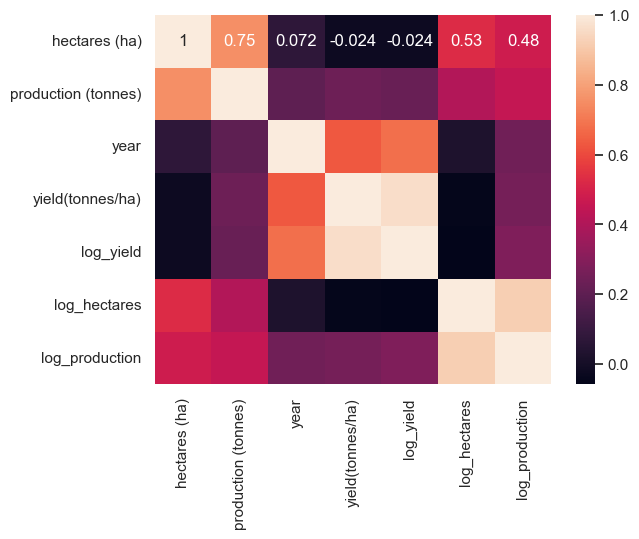

In [27]:
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True)

In [28]:
corr['production (tonnes)'].sort_values(ascending=False)

production (tonnes)    1.000000
hectares (ha)          0.752794
log_production         0.453352
log_hectares           0.405028
yield(tonnes/ha)       0.236592
log_yield              0.225808
year                   0.200686
Name: production (tonnes), dtype: float64

In [29]:
wheat_df = df[(df['crop'] == 'wheat')]
wheat_df.drop(['crop'], axis=1, inplace=True)
# sns.scatterplot(data=df, x='year', y='yield(tonnes/ha)', hue='subnational')
wheat_df = wheat_df[(wheat_df['year']) > 2006]

wheat_df
# sns.histplot(data=wheat_df, x='yield(tonnes/ha)')

C:\Users\Emalisa\AppData\Local\Temp\ipykernel_19008\1211715453.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wheat_df.drop(['crop'], axis=1, inplace=True)


,national,subnational,hectares (ha),production (tonnes),year,yield(tonnes/ha),log_yield,log_hectares,log_production
105,Austria,Austria,292976.0,1.443246e+06,2007,4.926156,1.779376,12.587849,14.182406
106,Austria,Austria,296775.0,1.729848e+06,2008,5.828819,1.921152,12.600733,14.363545
107,Austria,Austria,309034.0,1.568937e+06,2009,5.076907,1.804496,12.641210,14.265909
108,Austria,Austria,302852.0,1.554974e+06,2010,5.134436,1.813918,12.621003,14.256970
109,Austria,Austria,304334.0,1.830135e+06,2011,6.013574,1.947847,12.625884,14.419901
...,...,...,...,...,...,...,...,...,...
36702,China,zhejiang,75520.0,2.783000e+05,2013,3.685117,1.544391,11.232166,12.536459
36703,China,zhejiang,82120.0,3.095000e+05,2014,3.768875,1.562110,11.315949,12.642717
36704,China,zhejiang,89800.0,3.513000e+05,2015,3.912027,1.591687,11.405351,12.769399
36705,China,zhejiang,76590.0,2.539000e+05,2016,3.315054,1.462110,11.246235,12.444700


<Axes: xlabel='year', ylabel='yield(tonnes/ha)'>

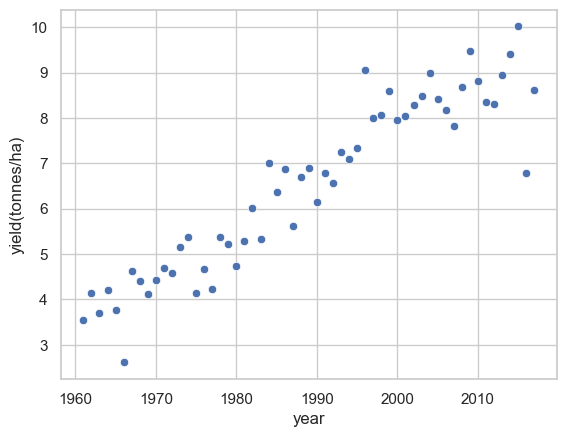

In [30]:
filtered_df = df[(df['crop'] == 'wheat') & (df['national'] == 'Belgium')]
sns.scatterplot(data=filtered_df, x='year', y='yield(tonnes/ha)')


this seems to indicate a relation between production and hectares, production and yield, yield and year (but not production and year)  
production and hectares seem linked (which makes sense), but yield and hectares seem very much not related (which is interesting), neither are yield and production. So it seems that more hectares give more crops, but it has no influence on crops per hectare (which makes a lot of sense actually, nvm).

remove harvest_year (it is the same as year)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


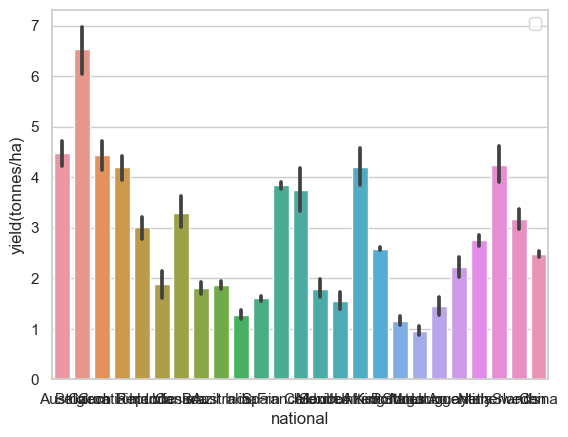

In [31]:
sns.barplot(y=df['yield(tonnes/ha)'], x=df['national'])
plt.legend()
plt.show()

It would maybe be interesting to see, while training the models, if there is higher accuracy between using all countries vs the 10 or 5 best countries.  
Let's look at what these best countries are.

In [32]:
df_wheat = df[df['crop'] == 'wheat']
df_winterwheat = df[df['crop'] == 'winter wheat']
df_springwheat = df[df['crop'] == 'spring wheat']
df_maize = df[df['crop'] == 'maize']
df_cereals = df[df['crop'] == 'cereals']


In [33]:

top_five_wheat = df_wheat.groupby('subnational').agg({'yield(tonnes/ha)': 'mean'}).nlargest(5, 'yield(tonnes/ha)')
top_five_springwheat = df_springwheat.groupby('subnational').agg({'yield(tonnes/ha)': 'mean'}).nlargest(5, 'yield(tonnes/ha)')
top_five_winterwheat = df_winterwheat.groupby('subnational').agg({'yield(tonnes/ha)': 'mean'}).nlargest(5, 'yield(tonnes/ha)')
top_five_cereals = df_cereals.groupby('subnational').agg({'yield(tonnes/ha)': 'mean'}).nlargest(5, 'yield(tonnes/ha)')
top_five_maize = df_maize.groupby('subnational').agg({'yield(tonnes/ha)': 'mean'}).nlargest(5, 'yield(tonnes/ha)')

top_five_wheat
df_wheat.subnational.unique()

array(['Austria', 'Belgium', 'Croatia', 'Czech Republic', 'Finland',
       'Canada', 'Rio Grande do Sul', 'Santa Catarina', 'Paraná',
       'New South Wales(b)', 'Victoria', 'Queensland', 'South Australia',
       'Western Australia', 'Tasmania', 'Northern Territory',
       'Australian Capital Territory', 'India', 'andalucia', 'aragon',
       'asturias', 'baleares', 'basque country', 'canary islands',
       'cantabria', 'castilla la mancha', 'castilla y leon', 'catalunya',
       'extremadura', 'galicia', 'la rioja', 'madrid', 'murcia',
       'navarra', 'valencia', 'Spain', 'Île-de-France',
       'Champagne-Ardenne', 'Picardy', 'Upper Normandy',
       'Centre-Val de Loire', 'Lower Normandy', 'Burgundy',
       'Nord-Pas-de-Calais', 'Lorraine', 'Franche-Comté',
       'Pays de la Loire', 'Brittany', 'Poitou-Charentes', 'Aquitaine',
       'Midi-Pyrénées', 'Limousin', 'Rhône-Alpes', 'Auvergne',
       'Languedoc-Roussillon', 'Provence-Alpes-Côte dAzur',
       'Val-de-Marne', 'Lo

In [34]:
top_five_springwheat

,yield(tonnes/ha)
subnational,
ARIZONA,6.240311
CALIFORNIA,5.513554
IDAHO,4.995824
NEW MEXICO,4.842106
OTHER STATES,4.156141


In [35]:
top_five_winterwheat

,yield(tonnes/ha)
subnational,
Netherlands,4.669394
NEVADA,3.748536
Sweden,3.592176
ARIZONA,3.549411
OTHER STATES,3.503802


In [36]:
top_five_maize
# df_maize.national.unique()

,yield(tonnes/ha)
subnational,
OTHER STATES,9.622481
Nord-Pas-de-Calais,6.901474
Lower Normandy,6.307944
Upper Normandy,5.838349
Île-de-France,5.728802


In [37]:
top_five_cereals

,yield(tonnes/ha)
subnational,
Morocco,0.961218


In [38]:
df_cereals

,national,subnational,crop,hectares (ha),production (tonnes),year,yield(tonnes/ha),log_yield,log_hectares,log_production
29532,Morocco,Morocco,cereals,3596.0,2046.6,1938,0.5700,0.451076,8.187855,7.624424
29533,Morocco,Morocco,cereals,4141.0,3841.9,1939,0.9300,0.657520,8.328934,8.253983
29534,Morocco,Morocco,cereals,4466.0,2998.8,1940,0.6700,0.512824,8.404472,8.006301
29535,Morocco,Morocco,cereals,4466.0,3950.9,1941,0.8800,0.631272,8.404472,8.281952
29536,Morocco,Morocco,cereals,4331.0,3432.5,1942,0.7900,0.582216,8.373785,8.141335
...,...,...,...,...,...,...,...,...,...,...
29607,Morocco,Morocco,cereals,5401005.0,9874543.0,2013,1.8283,1.039676,15.502096,16.105471
29608,Morocco,Morocco,cereals,4770494.0,6937687.0,2014,1.4543,0.897842,15.377961,15.752479
29609,Morocco,Morocco,cereals,5460480.0,11689100.0,2015,2.1407,1.144446,15.513047,16.274167
29610,Morocco,Morocco,cereals,3804496.0,3561589.0,2016,0.9362,0.660727,15.151694,15.085718


we should use subnational

In [69]:
df[df['national'] == 'Netherlands'].crop.unique()

array(['winter wheat', 'spring wheat'], dtype=object)

US 

In [45]:
country_counts = df['subnational'].value_counts()

# Get the country with the most rows
country_counts.idxmax()


'MINNESOTA'

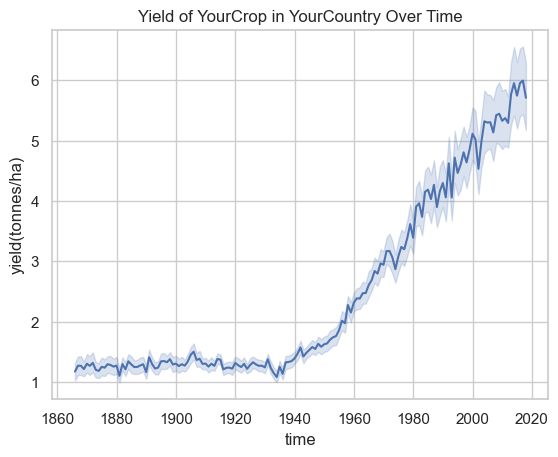

In [50]:
# Filter the DataFrame to include data for a specific country and crop
filtered_data = df[df['national'] == 'United States']

# Create a line plot
sns.lineplot(data=filtered_data, x='year', y='yield(tonnes/ha)')

# Set labels and title
plt.xlabel('time')
plt.ylabel('yield(tonnes/ha)')
plt.title('Yield of YourCrop in YourCountry Over Time')

# Show the plot
plt.show()

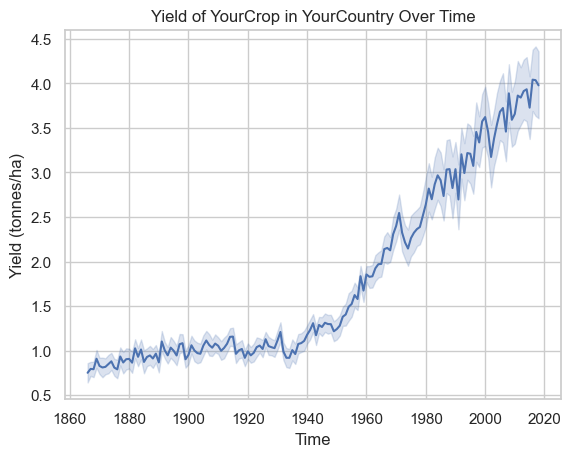

In [52]:
# Filter the DataFrame to include data for a specific country and crop
filtered_data = df[(df['national'] == 'United States') & (df['crop'] == 'wheat')]

# Create a line plot
sns.lineplot(data=filtered_data, x='year', y='yield(tonnes/ha)')

# Set labels and title
plt.xlabel('Time')
plt.ylabel('Yield (tonnes/ha)')
plt.title('Yield of Wheat in the United States Over Time')

# Show the plot
plt.show()

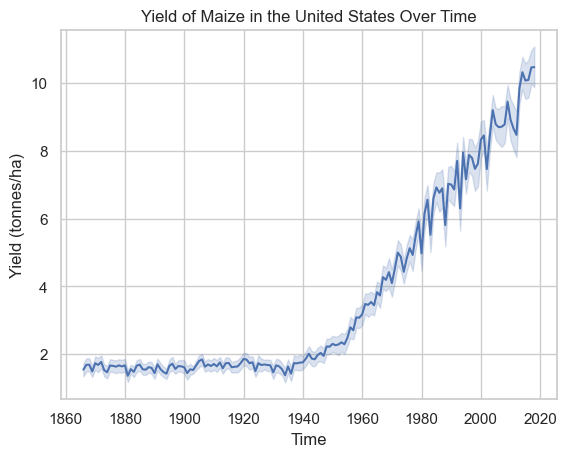

In [53]:
# Filter the DataFrame to include data for a specific country and crop
filtered_data = df[(df['national'] == 'United States') & (df['crop'] == 'maize')]

# Create a line plot
sns.lineplot(data=filtered_data, x='year', y='yield(tonnes/ha)')

# Set labels and title
plt.xlabel('Time')
plt.ylabel('Yield (tonnes/ha)')
plt.title('Yield of Maize in the United States Over Time')

# Show the plot
plt.show()

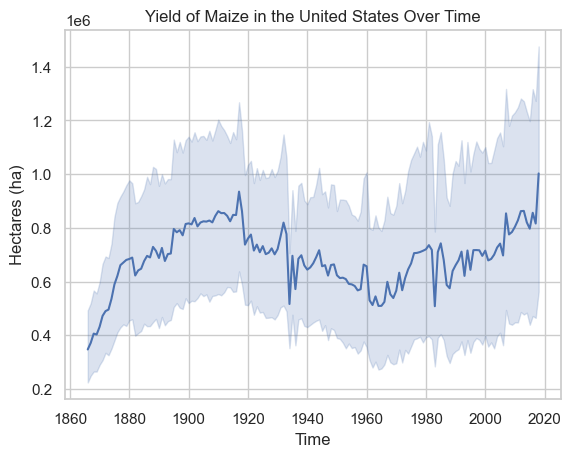

In [57]:
# Filter the DataFrame to include data for a specific country and crop
filtered_data = df[(df['national'] == 'United States') & (df['crop'] == 'maize')]

# Create a line plot
sns.lineplot(data=filtered_data, x='year', y='hectares (ha)')

# Set labels and title
plt.xlabel('Time')
plt.ylabel('Hectares (ha)')
plt.title('Yield of Maize in the United States Over Time')

# Show the plot
plt.show()

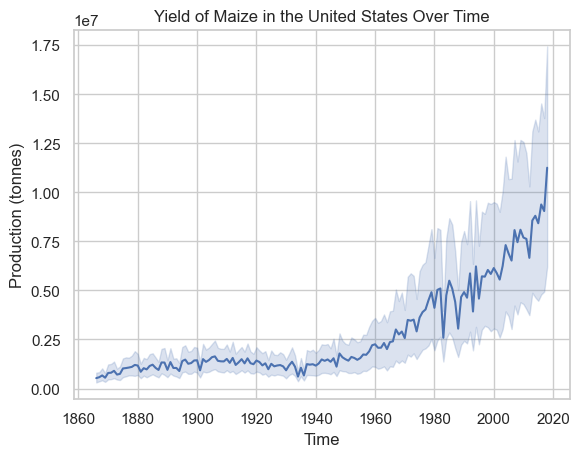

In [58]:
# Filter the DataFrame to include data for a specific country and crop
filtered_data = df[(df['national'] == 'United States') & (df['crop'] == 'maize')]

# Create a line plot
sns.lineplot(data=filtered_data, x='year', y='production (tonnes)')

# Set labels and title
plt.xlabel('Time')
plt.ylabel('Production (tonnes)')
plt.title('Yield of Maize in the United States Over Time')

# Show the plot
plt.show()

In [81]:
average_hectares_per_country = df[df['crop'] == 'wheat'].groupby('national')['yield(tonnes/ha)'].mean().sort_values(ascending=True)

# The result is a Series with the average hectares per country
print(average_hectares_per_country)

national
Portugal          1.161361
Brazil            1.179195
South Africa      1.205095
Australia         1.261837
Uruguay           1.329895
India             1.363857
Argentina         1.495822
Spain             1.602584
Canada            1.668937
United States     1.815193
China             2.054067
Italy             2.077832
Mexico            2.286721
Chile             2.431200
Finland           3.011344
France            3.336880
Czech Republic    4.200240
United Kingdom    4.208898
Croatia           4.427806
Austria           4.470356
Belgium           6.530132
Name: yield(tonnes/ha), dtype: float64


Wheat top five countries are Belgium, Austria, Croatia, United Kingdom, and Czech Republic   
We gaan kijken naar wheat yield, dit voorspellen in de tijd voor deze vijf landen.

In [ ]:
average_hectares_per_country = df.groupby('national')['hectares (ha)'].mean()

# The result is a Series with the average hectares per country
print(average_hectares_per_country)

In [75]:
df[df['year'] > 2000].describe()

,hectares (ha),production (tonnes),year,yield(tonnes/ha),log_yield,log_hectares,log_production
count,5.085000e+03,5.085000e+03,5085.000000,5085.000000,5085.000000,5085.000000,5085.000000
mean,8.364531e+05,3.701705e+06,2009.174631,5.334206,1.753345,11.781141,13.289095
std,2.344202e+06,9.702719e+06,5.063541,2.709950,0.437309,2.269954,2.336967
min,5.000000e+00,0.000000e+00,2001.000000,0.000000,0.000000,1.791759,0.000000
25%,3.595000e+04,1.673743e+05,2005.000000,3.260870,1.449473,10.489912,12.027994
50%,1.538920e+05,8.208143e+05,2009.000000,4.600000,1.722767,11.944013,13.618053
75%,6.702000e+05,2.659500e+06,2013.000000,7.272156,2.112895,13.415333,14.793649
max,3.147000e+07,1.342875e+08,2019.000000,14.750705,2.756885,17.264545,18.715494


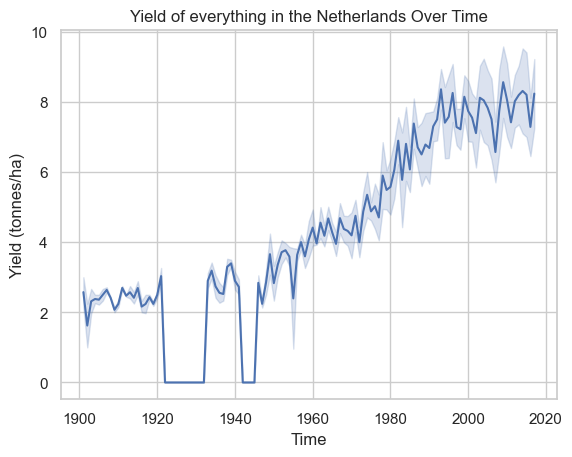

In [72]:
# Filter the DataFrame to include data for a specific country and crop
filtered_data = df[df['national'] == 'Netherlands']
# Create a line plot
sns.lineplot(data=filtered_data, x='year', y='yield(tonnes/ha)')

# Set labels and title
plt.xlabel('Time')
plt.ylabel('Yield (tonnes/ha)')
plt.title('Yield of everything in the Netherlands Over Time')

# Show the plot
plt.show()

In [80]:
df[df['crop'] == 'wheat'].national.unique()

array(['Austria', 'Belgium', 'Croatia', 'Czech Republic', 'Finland',
       'Canada', 'Brazil', 'Australia', 'India', 'Spain', 'France',
       'Chile', 'Mexico', 'South Africa', 'United Kingdom',
       'United States', 'Portugal', 'Uruguay', 'Argentina', 'Italy',
       'China'], dtype=object)